In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## IMPORT

In [ ]:
import os
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from collections import Counter
from scipy.stats import skew, kurtosis, entropy
from scipy.special import softmax
from scipy.optimize import minimize

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, average_precision_score, roc_auc_score
)
from xgboost import XGBClassifier

# Imbalanced Learning
try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    !pip install imbalanced-learn
    from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")

## CONFIGURATION

In [ ]:
# 데이터 경로 설정
PATHS = {
    "mon": "/dataset/closeworld/mon_standard.pkl",
    "unmon": "/dataset/openworld/unmon_standard10_3000.pkl"
}

In [ ]:
CONFIG = {
    'common': {
        'min_seq_length': 10,
        'test_size': 0.2,
        'random_state': 42,
        'n_jobs': -1,
    },

    'closed': {
        'n_monitored_classes': 95,
        'use_website_level': True,
        'corr_th': [1.0, 0.99, 0.98, 0.95, 0.9],
        'rf': {
            'n_estimators': 300,
            'max_depth': 30,
            'max_features': 'log2',
            'min_samples_split': 2,
            'min_samples_leaf': 1,
            'random_state': 42,
            'n_jobs': -1,
        },
        'xgb': {
            'n_estimators': 500,
            'min_child_weight': 1,
            'max_depth': 5,
            'learning_rate': 0.05,
            'subsample': 0.8,
            'gamma': 0.1,
            'colsample_bytree': 0.6,
            'random_state': 42,
            'n_jobs': -1,
        }
    },

    'open_binary': {
        'min_seq_length': 10,
        'test_size': 0.2,
        'unmon_label': -1,
        'n_monitored_classes': 95,
        'use_website_level': True,
        'val_size': 0.1,
        'corr_th': [1.0, 0.99, 0.98, 0.95, 0.9],
        'threshold_percentiles': [3.0, 5.0, 7.0, 10.0],
        'main_threshold_percentile': 5.0,
        'n_splits_cv': 5,
        'rf': {
            'n_estimators': 500,
            'max_depth': 20,
            'min_samples_split': 5,
            'class_weight': 'balanced',
            'random_state': 42,
            'n_jobs': -1,
        },
        'xgb': {
            'n_estimators': 400,
            'max_depth': 9,
            'learning_rate': 0.05,
            'subsample': 0.8,
            'colsample_bytree': 1.0,
            'tree_method': 'hist',
            'eval_metric': 'mlogloss',
            'random_state': 42,
            'n_jobs': -1,
        }
    },

    'open_multi': {
        'unmon_label': -1,
        'n_monitored_classes': 95,
        'use_website_level': True,
        'val_size': 0.1,
        'corr_th': [1.0, 0.99, 0.98, 0.95, 0.9],
        'threshold_percentiles': [10.0, 15.0, 20.0, 25.0, 30.0],
        'main_threshold_percentile': 5.0,
        'n_splits_cv': 5,
        'rf': {
            'n_estimators': 500,
            'max_depth': 20,
            'min_samples_split': 5,
            'min_samples_leaf': 1,
            'class_weight': 'balanced',
            'random_state': 42,
            'n_jobs': -1,
        },
        'xgb': {
            'n_estimators': 400,
            'max_depth': 9,
            'learning_rate': 0.05,
            'subsample': 0.8,
            'colsample_bytree': 1.0,
            'tree_method': 'hist',
            'eval_metric': 'mlogloss',
            'enable_categorical': False,
            'random_state': 42,
            'n_jobs': -1,
            'verbosity': 0,
        }
    }
}

In [ ]:
# 시나리오 선택
SCENARIO = 'closed'  # 'closed', 'open_binary', 'open_multi'
CURRENT_CONFIG = {**CONFIG['common'], **CONFIG[SCENARIO]}

## Feature Extraction

In [ ]:
def get_feature_names_base():
    return [
        "Total_Packets", "Num_Outgoing", "Num_Incoming", "Fraction_Incoming", "Fraction_Outgoing",
        "Mean_Size", "Std_Size", "Median_Size", "Max_Size", "Min_Size",
        "Skew_Size", "Kurt_Size", "Mean_Incoming_Size", "Mean_Outgoing_Size",
        "Total_Incoming_Bytes", "Total_Outgoing_Bytes",
        "Num_Bursts", "Mean_Burst_Length", "Std_Burst_Length", "Max_Burst_Length",
        "Mean_Burst_Size", "Max_Burst_Size",
        "CumNorm_Mean", "CumNorm_Std", "Max_Cumulative", "Min_Cumulative",
        "Total_Duration", "Mean_Inter_Time", "Std_Inter_Time", "Max_Inter_Time",
        "Packet_Rate", "Incoming_Rate", "Outgoing_Rate",
        "IAT_Out_Mean", "IAT_Out_Std", "IAT_Out_25th", "IAT_Out_75th",
        "Corr_Time_Size", "AutoCorr_Mean", "Interval_Mean", "Interval_Std",
        "First_30_Outgoing", "First_30_Incoming", "Last_30_Outgoing", "Last_30_Incoming",
        "Packets_First_Second", "Packets_Last_Second",
        "Size_25th", "Size_75th", "Size_IQR",
        "Direction_Entropy", "Size_Bin_Entropy", "Burst_Direction_Entropy", "IAT_Bin_Entropy"
    ]

In [ ]:
def extract_features_final(trace: dict) -> dict:
    ts = np.array(trace["timestamp"], dtype=float)
    sz = np.array(trace["size"], dtype=float)
    if len(ts) > 1:
        idx = np.argsort(ts)
        ts, sz = ts[idx], sz[idx]
    n = len(sz)
    if n == 0: return {k: 0.0 for k in get_feature_names_base()}

    feats = {}
    abs_sz = np.abs(sz)

    # 1) Basic / Direction Features
    out_mask = sz > 0
    in_mask = sz < 0
    n_out = np.sum(out_mask)
    n_in = np.sum(in_mask)

    feats["Total_Packets"] = n
    feats["Num_Outgoing"] = int(n_out)
    feats["Num_Incoming"] = int(n_in)
    feats["Fraction_Incoming"] = n_in / n if n > 0 else 0.0
    feats["Fraction_Outgoing"] = n_out / n if n > 0 else 0.0

    # 2) Size Statistics
    feats["Mean_Size"] = float(np.mean(sz))
    feats["Std_Size"] = float(np.std(sz))
    feats["Median_Size"] = float(np.median(sz))
    feats["Max_Size"] = float(np.max(sz))
    feats["Min_Size"] = float(np.min(sz))
    feats["Skew_Size"] = float(skew(sz)) if n > 1 else 0.0
    feats["Kurt_Size"] = float(kurtosis(sz)) if n > 1 else 0.0

    # Incoming/Outgoing splits
    in_sz = abs_sz[in_mask]
    out_sz = sz[out_mask]
    feats["Mean_Incoming_Size"] = float(np.mean(in_sz)) if len(in_sz) > 0 else 0.0
    feats["Mean_Outgoing_Size"] = float(np.mean(out_sz)) if len(out_sz) > 0 else 0.0
    feats["Total_Incoming_Bytes"] = float(np.sum(in_sz))
    feats["Total_Outgoing_Bytes"] = float(np.sum(out_sz))

    # 3) Burst Features
    bursts = []
    burst_directions = []
    if n > 0:
        cur_dir = np.sign(sz[0])
        cur_len = 1
        cur_sum = abs(sz[0])
        for i in range(1, n):
            d = np.sign(sz[i])
            if d == cur_dir:
                cur_len += 1
                cur_sum += abs(sz[i])
            else:
                bursts.append({"length": cur_len, "size": cur_sum})
                burst_directions.append(cur_dir)
                cur_dir = d
                cur_len = 1
                cur_sum = abs(sz[i])
        bursts.append({"length": cur_len, "size": cur_sum})
        burst_directions.append(cur_dir)

    if bursts:
        b_len = np.array([b["length"] for b in bursts])
        b_sz = np.array([b["size"] for b in bursts])
        feats["Num_Bursts"] = len(bursts)
        feats["Mean_Burst_Length"] = float(np.mean(b_len))
        feats["Std_Burst_Length"] = float(np.std(b_len))
        feats["Max_Burst_Length"] = float(np.max(b_len))
        feats["Mean_Burst_Size"] = float(np.mean(b_sz))
        feats["Max_Burst_Size"] = float(np.max(b_sz))
    else:
        feats["Num_Bursts"] = 0
        feats["Mean_Burst_Length"] = 0.0
        feats["Std_Burst_Length"] = 0.0
        feats["Max_Burst_Length"] = 0.0
        feats["Mean_Burst_Size"] = 0.0
        feats["Max_Burst_Size"] = 0.0

    # 4) Normalized Cumulative Stats
    cum = np.cumsum(sz)
    max_abs_cum = np.max(np.abs(cum)) if np.max(np.abs(cum)) != 0 else 1.0
    cum_norm = cum / max_abs_cum

    feats["CumNorm_Mean"] = float(np.mean(cum_norm))
    feats["CumNorm_Std"] = float(np.std(cum_norm))
    feats["Max_Cumulative"] = float(np.max(cum))
    feats["Min_Cumulative"] = float(np.min(cum))

    # 5) Time-based Features
    if n > 1:
        duration = ts[-1] - ts[0]
        feats["Total_Duration"] = duration if duration > 0 else 0.0

        inter = np.diff(ts)
        inter = inter[inter > 0]
        feats["Mean_Inter_Time"] = float(np.mean(inter)) if len(inter) > 0 else 0.0
        feats["Std_Inter_Time"] = float(np.std(inter)) if len(inter) > 0 else 0.0
        feats["Max_Inter_Time"] = float(np.max(inter)) if len(inter) > 0 else 0.0

        feats["Packet_Rate"] = n / duration if duration > 0 else 0.0
        feats["Incoming_Rate"] = n_in / duration if duration > 0 else 0.0
        feats["Outgoing_Rate"] = n_out / duration if duration > 0 else 0.0
    else:
        feats["Total_Duration"] = 0.0
        feats["Mean_Inter_Time"] = 0.0
        feats["Std_Inter_Time"] = 0.0
        feats["Max_Inter_Time"] = 0.0
        feats["Packet_Rate"] = 0.0
        feats["Incoming_Rate"] = 0.0
        feats["Outgoing_Rate"] = 0.0

    # Outgoing-only IAT
    out_idx = np.where(sz > 0)[0]
    if len(out_idx) > 1:
        t_out = np.sort(ts[out_idx])
        iat_out = np.diff(t_out)
        iat_out = iat_out[iat_out > 0]
        feats["IAT_Out_Mean"] = float(np.mean(iat_out)) if len(iat_out) > 0 else 0.0
        feats["IAT_Out_Std"] = float(np.std(iat_out)) if len(iat_out) > 0 else 0.0
        feats["IAT_Out_25th"] = float(np.percentile(iat_out, 25)) if len(iat_out) > 0 else 0.0
        feats["IAT_Out_75th"] = float(np.percentile(iat_out, 75)) if len(iat_out) > 0 else 0.0
    else:
        feats["IAT_Out_Mean"] = 0.0
        feats["IAT_Out_Std"] = 0.0
        feats["IAT_Out_25th"] = 0.0
        feats["IAT_Out_75th"] = 0.0

    # 6) Correlation Features
    if np.std(ts) > 0 and np.std(sz) > 0:
        feats["Corr_Time_Size"] = float(np.corrcoef(ts, sz)[0, 1])
    else:
        feats["Corr_Time_Size"] = 0.0

    # Autocorrelation 1~4
    ac_vals = []
    for lag in range(1, min(5, n // 2)):
        s1, s2 = sz[:-lag], sz[lag:]
        if np.std(s1) > 0 and np.std(s2) > 0:
            ac_vals.append(np.corrcoef(s1, s2)[0, 1])
    feats["AutoCorr_Mean"] = float(np.mean(ac_vals)) if ac_vals else 0.0

    # 7) Interval-based Features
    if feats.get("Total_Duration", 0) > 0:
        N = 5
        bins = np.linspace(ts[0], ts[-1], N + 1)
        sums = []
        for i in range(N):
            idx = np.where((ts >= bins[i]) & (ts < bins[i + 1]))[0]
            sums.append(float(np.sum(abs_sz[idx])))

        feats["Interval_Mean"] = float(np.mean(sums))
        feats["Interval_Std"] = float(np.std(sums))
    else:
        feats["Interval_Mean"] = 0.0
        feats["Interval_Std"] = 0.0

    # 8) Position-based Features
    K = min(30, n)
    first = sz[:K]
    last = sz[-K:]

    feats["First_30_Outgoing"] = int(np.sum(first > 0))
    feats["First_30_Incoming"] = int(np.sum(first < 0))
    feats["Last_30_Outgoing"] = int(np.sum(last > 0))
    feats["Last_30_Incoming"] = int(np.sum(last < 0))

    feats["Packets_First_Second"] = int(np.sum(ts <= (ts[0] + 1.0)))
    feats["Packets_Last_Second"] = int(np.sum(ts >= (ts[-1] - 1.0)))

    # 9) Percentile Features
    feats["Size_25th"] = float(np.percentile(sz, 25))
    feats["Size_75th"] = float(np.percentile(sz, 75))
    feats["Size_IQR"] = feats["Size_75th"] - feats["Size_25th"]

    # 10) ENTROPY FEATURES
    from collections import Counter

    def safe_entropy(values):
        if len(values) == 0:
            return 0.0
        counts = Counter(values)
        probs = np.array(list(counts.values())) / len(values)
        return float(entropy(probs))

    # 10-1) Direction Entropy
    directions = np.sign(sz)
    directions = directions[directions != 0]
    feats["Direction_Entropy"] = safe_entropy(directions)

    # 10-2) Size Bin Entropy
    if n > 0:
        n_bins = 20
        size_bins = np.digitize(abs_sz, bins=np.linspace(0, 512, n_bins + 1))
        feats["Size_Bin_Entropy"] = safe_entropy(size_bins)
    else:
        feats["Size_Bin_Entropy"] = 0.0

    # 10-3) Burst Direction Entropy
    if len(burst_directions) > 0:
        feats["Burst_Direction_Entropy"] = safe_entropy(burst_directions)
    else:
        feats["Burst_Direction_Entropy"] = 0.0

    # 10-4) IAT Bin Entropy
    if len(inter) > 0 and feats.get("Total_Duration", 0) > 0:
        iat_normalized = inter / feats["Total_Duration"]
        iat_bins = np.digitize(iat_normalized, bins=np.linspace(0, 1, 11))
        feats["IAT_Bin_Entropy"] = safe_entropy(iat_bins)
    else:
        feats["IAT_Bin_Entropy"] = 0.0

    feats["label"] = trace["label"]

    return feats

## Data Loading

In [ ]:
def load_dataset():
    print(">>> Loading Data...")
    if 'PATHS' not in globals(): raise NameError("PATHS not defined.")
    with open(PATHS['mon'], 'rb') as f: mon_data = pickle.load(f)

    traces = []
    if isinstance(mon_data, dict):
        for cls_id, samples in mon_data.items():
            if SCENARIO == 'closed' and cls_id >= 950: continue
            label = int(cls_id)//10 if CURRENT_CONFIG.get('use_website_level') else int(cls_id)

            for s in samples:
                if len(s) < CURRENT_CONFIG['min_seq_length']: continue
                traces.append({"timestamp": np.abs(np.array(s)), "size": np.sign(np.array(s))*512, "label": label})

    if SCENARIO != 'closed':
        with open(PATHS['unmon'], 'rb') as f: unmon_data = pickle.load(f)
        for s in unmon_data:
            if len(s) < CURRENT_CONFIG['min_seq_length']: continue
            traces.append({"timestamp": np.abs(np.array(s)), "size": np.sign(np.array(s))*512, "label": CURRENT_CONFIG['unmon_label']})

    return traces

In [ ]:
# Execution
all_traces = load_dataset()
print(f"Total Traces: {len(all_traces)}")

df_list = []
for t in tqdm(all_traces, desc="Extracting Features"):
    df_list.append(extract_features_final(t))
df_all = pd.DataFrame(df_list).fillna(0)
X = df_all.drop(columns=['label'])
y = df_all['label'].values
print(f"Feature Extraction Done. Shape: {X.shape}")

>>> Loading Data...
Total Traces: 19000


Extracting Features:   0%|          | 0/19000 [00:00<?, ?it/s]

Feature Extraction Done. Shape: (19000, 54)


## Preprocessing Classes

In [ ]:
class CustomLabelEncoder:
    """XGBoost용 (-1 라벨 처리 및 복원)"""
    def __init__(self):
        self.mapper = {}
        self.inv_mapper = {}
    def fit(self, y):
        uniques = sorted(np.unique(y))
        self.mapper = {v: i for i, v in enumerate(uniques)}
        self.inv_mapper = {i: v for i, v in enumerate(uniques)}
        return self
    def transform(self, y):
        return np.array([self.mapper.get(v, -1) for v in y])
    def inverse_transform(self, y_enc):
        return np.array([self.inv_mapper.get(v, -1) for v in y_enc])
    def fit_transform(self, y):
        self.fit(y)
        return self.transform(y)

In [ ]:
class EnhancedPreprocessor:
    """
    Correlation threshold + StandardScaler
    sklearn Pipeline 호환을 위해 타입 검증 완화
    """
    def __init__(self, correlation_threshold):
        try:
            self.correlation_threshold = float(correlation_threshold)
        except (TypeError, ValueError) as e:
            raise TypeError(
                f"correlation_threshold must be numeric, got {type(correlation_threshold).__name__}"
            ) from e

        if not (0 <= self.correlation_threshold <= 1):
            raise ValueError(
                f"correlation_threshold must be in [0,1], got {self.correlation_threshold}"
            )

        self.scaler = StandardScaler()
        self.features_to_drop = []
        self.feature_names = None

    def fit(self, X_train: pd.DataFrame):
        # 1. Correlation-based removal
        corr_matrix = X_train.corr().abs()
        upper = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )
        self.features_to_drop = [
            col for col in upper.columns
            if any(upper[col] > self.correlation_threshold)
        ]

        # 2. Remove correlated features
        X_reduced = X_train.drop(columns=self.features_to_drop)
        self.feature_names = X_reduced.columns.tolist()

        # 3. Fit scaler
        self.scaler.fit(X_reduced)

        # 4. Print info
        print(f"   [EnhancedPreprocessor] Correlation threshold: {self.correlation_threshold}")
        print(f"   [EnhancedPreprocessor] Removed {len(self.features_to_drop)} features")
        print(f"   [EnhancedPreprocessor] Final: {len(self.feature_names)} features")

        return self

    def transform(self, X: pd.DataFrame) -> np.ndarray:
        # Drop features that were removed during fit
        X_reduced = X.drop(columns=[c for c in self.features_to_drop if c in X.columns])
        return self.scaler.transform(X_reduced[self.feature_names])

    def fit_transform(self, X_train: pd.DataFrame) -> np.ndarray:
        self.fit(X_train)
        return self.transform(X_train)

In [ ]:
class CorrPreprocessor:
    """[Open World 전용] Simple Correlation Removal + Scaling"""
    def __init__(self, correlation_threshold=0.98):
        self.correlation_threshold = correlation_threshold
        self.scaler = StandardScaler()
        self.features_to_drop = []
        self.feature_names = None

    def fit(self, X):
        corr = X.corr().abs()
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        self.features_to_drop = [c for c in upper.columns if any(upper[c] > self.correlation_threshold)]
        X_reduced = X.drop(columns=self.features_to_drop)
        self.feature_names = X_reduced.columns.tolist()
        self.scaler.fit(X_reduced)
        print(f"  [CorrPrep] Dropped {len(self.features_to_drop)} features (Th={self.correlation_threshold})")
        return self

    def transform(self, X):
        X_reduced = X.drop(columns=[c for c in self.features_to_drop if c in X.columns])
        return self.scaler.transform(X_reduced[self.feature_names])

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [ ]:
class TemperatureScaler:
    """Probability Calibration for OSR"""
    def __init__(self):
        self.T = 1.0
    def fit(self, logits, y_idx):
        def nll(T_arr):
            scaled = logits / T_arr[0]
            probs = softmax(scaled, axis=1)
            n = probs.shape[0]
            p = probs[np.arange(n), y_idx]
            return float(-np.log(p + 1e-12).mean())
        res = minimize(nll, x0=np.array([1.0]), bounds=[(0.1, 10.0)], method='L-BFGS-B')
        self.T = float(res.x[0])
        return self
    def transform(self, logits):
        return softmax(logits / self.T, axis=1)

## Training & Evaluation Logic

In [ ]:
def evaluate_open_world(y_true, y_pred, y_proba, unmon_label=-1, scenario='None'):
    print(f"\n{'='*70}")
    print(f"  EVALUATION ({scenario.upper()})")
    print(f"{'='*70}")

    # 기본 메트릭 초기화
    tpr = fpr = tnr = precision = recall = roc_auc = pr_auc = 0.0
    mon_acc = mon_f1 = 0.0

    ## 1. Overall Performance (모든 시나리오 공통)
    overall_acc = accuracy_score(y_true, y_pred)
    overall_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    ## 2. Open-World 전용 메트릭 계산
    if scenario != 'closed':
        # Binary Classification Performance
        y_binary_true = (y_true != unmon_label).astype(int)
        y_binary_pred = (y_pred != unmon_label).astype(int)

        # Masks for actual classes
        monitored_mask = (y_true != unmon_label)
        unmonitored_mask = (y_true == unmon_label)

        # TPR: True Positive Rate (실제 monitored 중 monitored로 예측)
        tpr = (y_binary_pred[monitored_mask] == 1).sum() / monitored_mask.sum() if monitored_mask.sum() > 0 else 0.0

        # FPR: False Positive Rate (실제 unmonitored 중 monitored로 오예측)
        fpr = (y_binary_pred[unmonitored_mask] == 1).sum() / unmonitored_mask.sum() if unmonitored_mask.sum() > 0 else 0.0

        # TNR: True Negative Rate
        tnr = 1 - fpr

        # Precision & Recall
        precision = precision_score(y_binary_true, y_binary_pred, pos_label=1, zero_division=0)
        recall = recall_score(y_binary_true, y_binary_pred, pos_label=1, zero_division=0)

        # Confidence scores 계산
        if scenario == 'open_binary':
            # Binary: monitored 클래스 확률
            if y_proba.shape[1] == 2:
                confidence_scores = y_proba[:, 1]
            else:
                confidence_scores = y_proba[:, 0]
        else:  # open_multi
            # Multi-class: 최대 확률
            confidence_scores = np.max(y_proba, axis=1)

        # ROC-AUC
        try:
            roc_auc = roc_auc_score(y_binary_true, confidence_scores)
        except ValueError as e:
            roc_auc = 0.0
            print(f"  [Warning] ROC-AUC calculation failed: {e}")

        # PR-AUC
        try:
            pr_auc = average_precision_score(y_binary_true, confidence_scores)
        except ValueError as e:
            pr_auc = 0.0
            print(f"  [Warning] PR-AUC calculation failed: {e}")

        # Binary Detection 결과 출력
        print(f"\n[Binary Detection: Monitored vs Unmonitored]")
        print(f"  TPR (True Positive Rate / Recall): {tpr:.4f}")
        print(f"  FPR (False Positive Rate): {fpr:.4f}")
        print(f"  TNR (True Negative Rate): {tnr:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  ROC-AUC: {roc_auc:.4f}")
        print(f"  PR-AUC: {pr_auc:.4f}")

        # Monitored-only Performance
        mon_mask = (y_true != unmon_label) & (y_pred != unmon_label)

        if mon_mask.sum() > 0:
            mon_acc = accuracy_score(y_true[mon_mask], y_pred[mon_mask])
            mon_f1 = f1_score(y_true[mon_mask], y_pred[mon_mask], average='macro', zero_division=0)

    ## 3. Overall Performance 출력 (모든 시나리오)
    print(f"\n[Overall Performance]")
    print(f"  Overall Accuracy: {overall_acc:.4f}")
    print(f"  Overall Macro F1: {overall_f1:.4f}")

    ## 4. Monitored 성능 출력 (Open-World만)
    if scenario != 'closed':
        if mon_mask.sum() > 0:
            if scenario == 'open_multi':
                print(f"\n[Monitored 95-Class Performance]")
                print(f"  Accuracy (among detected monitored): {mon_acc:.4f}")
                print(f"  Macro F1 (among monitored): {mon_f1:.4f}")
            elif scenario == 'open_binary':
                print(f"\n[Monitored Class Performance]")
                print(f"  Accuracy (among detected monitored): {mon_acc:.4f}")
                print(f"  Macro F1 (among monitored): {mon_f1:.4f}")
        else:
            print(f"\n[Monitored Performance]")
            print(f"  No samples predicted as monitored")

    print(f"{'='*70}\n")

    ## Return metrics
    return {
        'TPR': tpr,
        'FPR': fpr,
        'Precision': precision,
        'Recall': recall,
        'ROC_AUC': roc_auc,
        'PR_AUC': pr_auc,
        'TNR': tnr,
        'overall_acc': overall_acc,
        'overall_f1': overall_f1,
        'monitored_acc': mon_acc,
        'monitored_f1': mon_f1
    }

In [ ]:
def train_model_wrapper(algo, X_tr, y_tr, X_te, y_te, params, unmon_label=-1):
    """모델 학습 및 평가"""
    p = params.copy()
    if 'corr_th' in p: del p['corr_th']

    if algo == 'rf':
        clf = RandomForestClassifier(n_jobs=-1, random_state=42, **p)
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_te)
        y_proba = clf.predict_proba(X_te)

    elif algo == 'xgb':
        # Label Encoding for XGBoost
        le = CustomLabelEncoder()
        y_tr_enc = le.fit_transform(y_tr)

        clf = XGBClassifier(
            n_estimators=p['n_estimators'],
            max_depth=p['max_depth'],
            learning_rate=p['learning_rate'],
            subsample=p.get('subsample', 0.8),
            colsample_bytree=p.get('colsample_bytree', 0.8),
            objective='multi:softprob',
            num_class=len(le.mapper),
            use_label_encoder=False,
            eval_metric='mlogloss',
            random_state=42
        )
        clf.fit(X_tr, y_tr_enc)

        y_pred_enc = clf.predict(X_te)
        y_pred = le.inverse_transform(y_pred_enc)
        y_proba = clf.predict_proba(X_te)

    else:
        raise ValueError(f"Unknown algorithm: {algo}")

    # Basic metrics
    acc = accuracy_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred, average='macro')

    print(f"\n[{algo.upper()}] Basic Metrics:")
    print(f"  Overall Accuracy: {acc:.4f}")
    print(f"  Macro F1-Score: {f1:.4f}")

    # Open-World Detailed Evaluation
    detailed_metrics = evaluate_open_world(y_te, y_pred, y_proba, unmon_label)

    return clf, {
        'accuracy': acc,
        'f1_macro': f1,
        'y_pred': y_pred,
        'y_proba': y_proba,
        **detailed_metrics
    }

In [ ]:
def calculate_class_weights(y: np.ndarray):
    """클래스 가중치 계산 (불균형 처리)"""
    from collections import Counter
    cnt = Counter(y)
    n = len(y)
    c = len(cnt)
    return {cls: n / (c * cnt[cls]) for cls in cnt.keys()}

## MAIN: CLOSED & OPEN WORLD

In [ ]:
if SCENARIO == 'closed':
    ## CLOSED WORLD
    print("\n" + "="*80)
    print(" CLOSED WORLD SCENARIO")
    print("="*80)

    results_closed = []
    for corr_th in CURRENT_CONFIG['corr_th']:
        print(f"\n[Closed] Testing with Correlation Threshold: {corr_th}")

        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=CURRENT_CONFIG['test_size'],
            random_state=CURRENT_CONFIG['random_state'],
            stratify=y
        )

        prep = EnhancedPreprocessor(correlation_threshold=corr_th)
        X_train_prep = prep.fit_transform(X_train)
        X_test_prep = prep.transform(X_test)

        # RF Training
        print("\n[RF Training]")
        rf_model = RandomForestClassifier(**CURRENT_CONFIG['rf'])
        rf_model.fit(X_train_prep, y_train)
        rf_pred = rf_model.predict(X_test_prep)
        rf_acc = accuracy_score(y_test, rf_pred)
        rf_f1 = f1_score(y_test, rf_pred, average='macro')
        print(f"  RF Accuracy: {rf_acc:.4f}")
        print(f"  RF Macro F1: {rf_f1:.4f}")

        # XGB Training
        print("\n[XGB Training]")
        le = CustomLabelEncoder()
        y_train_enc = le.fit_transform(y_train)

        xgb_model = XGBClassifier(
            objective='multi:softprob',
            num_class=len(le.mapper),
            use_label_encoder=False,
            **CURRENT_CONFIG['xgb']
        )
        xgb_model.fit(X_train_prep, y_train_enc)
        xgb_pred_enc = xgb_model.predict(X_test_prep)
        xgb_pred = le.inverse_transform(xgb_pred_enc)
        xgb_acc = accuracy_score(y_test, xgb_pred)
        xgb_f1 = f1_score(y_test, xgb_pred, average='macro')
        print(f"  XGB Accuracy: {xgb_acc:.4f}")
        print(f"  XGB Macro F1: {xgb_f1:.4f}")

        results_closed.append({
            'corr_th': corr_th,
            'rf_acc': rf_acc,
            'rf_f1': rf_f1,
            'xgb_acc': xgb_acc,
            'xgb_f1': xgb_f1
        })

    df_closed = pd.DataFrame(results_closed)
    print("\n" + "="*80)
    print("[Closed World Results Summary]")
    print("="*80)
    print(df_closed)


elif SCENARIO == 'open_binary':
    ## OPEN-WORLD BINARY CLASSIFICATION
    print("\n" + "="*80)
    print(" OPEN-WORLD BINARY CLASSIFICATION SCENARIO")
    print("="*80)

    # Binary label 생성: Monitored=1, Unmonitored=-1
    y_binary = np.where(y == CURRENT_CONFIG['unmon_label'], -1, 1)
    print(f"  Monitored samples (label=1): {np.sum(y_binary == 1)}")
    print(f"  Unmonitored samples (label=-1): {np.sum(y_binary == -1)}")

    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_binary,
        test_size=CURRENT_CONFIG['test_size'],
        random_state=CURRENT_CONFIG['random_state'],
        stratify=y_binary
    )

    results_binary = []

    for corr_th in CURRENT_CONFIG['corr_th']:
        print(f"\n[Binary] Testing with Correlation Threshold: {corr_th}")

        # 전처리
        prep = EnhancedPreprocessor(correlation_threshold=corr_th)
        X_train_prep = prep.fit_transform(X_train)
        X_test_prep = prep.transform(X_test)

        # RF 모델 학습 (한 번만)
        print("\n[RF Binary Classification Training]")
        rf_model = RandomForestClassifier(**CURRENT_CONFIG['rf'])
        rf_model.fit(X_train_prep, y_train)

        # XGB 모델 학습 (한 번만)
        print("\n[XGB Binary Classification Training]")
        le = CustomLabelEncoder()
        y_train_enc = le.fit_transform(y_train)

        xgb_params = CURRENT_CONFIG['xgb'].copy()
        xgb_params['objective'] = 'binary:logistic'
        xgb_params['use_label_encoder'] = False
        if 'eval_metric' not in xgb_params:
            xgb_params['eval_metric'] = 'logloss'

        xgb_model = XGBClassifier(**xgb_params)
        xgb_model.fit(X_train_prep, y_train_enc)

        # Threshold 튜닝
        for th_pct in CURRENT_CONFIG['threshold_percentiles']:
            print(f"\n  Testing Threshold Percentile: {th_pct}%")

            ## RF with Threshold
            rf_proba = rf_model.predict_proba(X_test_prep)
            rf_conf = np.max(rf_proba, axis=1)
            rf_threshold = np.percentile(rf_conf, th_pct)

            rf_pred = rf_model.predict(X_test_prep)
            rf_pred_thresholded = rf_pred.copy()
            rf_pred_thresholded[rf_conf < rf_threshold] = -1

            print(f"    RF Threshold: {rf_threshold:.4f}")
            rf_metrics = evaluate_open_world(
                y_true=y_test,
                y_pred=rf_pred_thresholded,
                y_proba=rf_proba,
                unmon_label=-1,
                scenario='open_binary'
            )

            results_binary.append({
                'Model': 'RF',
                'Corr_Th': corr_th,
                'Threshold_Percentile': th_pct,
                'Threshold_Value': rf_threshold,
                **rf_metrics
            })

            ## XGB with Threshold
            xgb_proba = xgb_model.predict_proba(X_test_prep)
            xgb_conf = np.max(xgb_proba, axis=1)
            xgb_threshold = np.percentile(xgb_conf, th_pct)

            xgb_pred_enc = xgb_model.predict(X_test_prep)
            xgb_pred = le.inverse_transform(xgb_pred_enc)
            xgb_pred_thresholded = xgb_pred.copy()
            xgb_pred_thresholded[xgb_conf < xgb_threshold] = -1

            print(f"    XGB Threshold: {xgb_threshold:.4f}")
            xgb_metrics = evaluate_open_world(
                y_true=y_test,
                y_pred=xgb_pred_thresholded,
                y_proba=xgb_proba,
                unmon_label=-1,
                scenario='open_binary'
            )

            results_binary.append({
                'Model': 'XGB',
                'Corr_Th': corr_th,
                'Threshold_Percentile': th_pct,
                'Threshold_Value': xgb_threshold,
                **xgb_metrics
            })

    df_binary = pd.DataFrame(results_binary)
    print("\n" + "="*80)
    print("[Binary Classification Results Summary]")
    print("="*80)
    print(df_binary)


elif SCENARIO == 'open_multi':
    ## OPEN WORLD - MULTI-CLASS
    print("\n" + "="*80)
    print(" OPEN WORLD SCENARIO: OPEN-MULTI")
    print("="*80)

    # Split monitored/unmonitored
    mon_mask = y != CURRENT_CONFIG['unmon_label']
    X_mon, y_mon = X[mon_mask], y[mon_mask]
    X_unmon, y_unmon = X[~mon_mask], y[~mon_mask]

    print(f"  Monitored samples: {len(X_mon)}")
    print(f"  Unmonitored samples: {len(X_unmon)}")

    results_open = []
    results_96class = []

    for corr_th in CURRENT_CONFIG['corr_th']:
        print(f"\n[Open] Testing with Correlation Threshold: {corr_th}")

        # Split monitored data
        X_mon_train, X_mon_test, y_mon_train, y_mon_test = train_test_split(
            X_mon, y_mon,
            test_size=CURRENT_CONFIG['test_size'],
            random_state=CURRENT_CONFIG['random_state'],
            stratify=y_mon
        )

        # Split unmonitored data
        X_unmon_train, X_unmon_test, y_unmon_train, y_unmon_test = train_test_split(
            X_unmon, y_unmon,
            test_size=CURRENT_CONFIG['test_size'],
            random_state=CURRENT_CONFIG['random_state']
        )

        # Preprocessing (fit on monitored only)
        prep = EnhancedPreprocessor(correlation_threshold=corr_th)
        X_mon_train_prep = prep.fit_transform(X_mon_train)
        X_mon_test_prep = prep.transform(X_mon_test)
        X_unmon_test_prep = prep.transform(X_unmon_test)

        # Train RF on monitored data
        print("\n[RF Training on Monitored Data]")
        rf_model = RandomForestClassifier(**CURRENT_CONFIG['rf'])
        rf_model.fit(X_mon_train_prep, y_mon_train)

        # Train XGB on monitored data
        print("\n[XGB Training on Monitored Data]")
        le = CustomLabelEncoder()
        y_mon_train_enc = le.fit_transform(y_mon_train)
        xgb_model = XGBClassifier(
            objective='multi:softprob',
            num_class=len(le.mapper),
            use_label_encoder=False,
            **CURRENT_CONFIG['xgb']
        )
        xgb_model.fit(X_mon_train_prep, y_mon_train_enc)

        # Test with different thresholds
        for th_pct in CURRENT_CONFIG['threshold_percentiles']:
            print(f"\n  Testing Threshold Percentile: {th_pct}%")

            # Combine all test data
            X_test_all = np.vstack([X_mon_test_prep, X_unmon_test_prep])
            y_test_all = np.concatenate([y_mon_test, y_unmon_test])

            # RF predictions
            rf_proba_all = rf_model.predict_proba(X_test_all)
            rf_pred_all = rf_model.predict(X_test_all)
            rf_conf_all = np.max(rf_proba_all, axis=1)

            # Determine RF threshold from monitored test data only
            rf_proba_mon = rf_model.predict_proba(X_mon_test_prep)
            rf_conf_mon = np.max(rf_proba_mon, axis=1)
            rf_threshold = np.percentile(rf_conf_mon, th_pct)

            # Apply threshold
            rf_pred_all[rf_conf_all < rf_threshold] = CURRENT_CONFIG['unmon_label']

            # Evaluate RF
            print("\n  [RF Evaluation]")
            rf_metrics = evaluate_open_world(
                y_test_all, rf_pred_all, rf_proba_all,
                unmon_label=CURRENT_CONFIG['unmon_label'],
                scenario='open_multi'
            )

            # XGB predictions
            xgb_proba_all = xgb_model.predict_proba(X_test_all)
            xgb_pred_all_enc = xgb_model.predict(X_test_all)
            xgb_pred_all = le.inverse_transform(xgb_pred_all_enc)
            xgb_conf_all = np.max(xgb_proba_all, axis=1)

            # Determine XGB threshold from monitored test data only
            xgb_proba_mon = xgb_model.predict_proba(X_mon_test_prep)
            xgb_conf_mon = np.max(xgb_proba_mon, axis=1)
            xgb_threshold = np.percentile(xgb_conf_mon, th_pct)

            # Apply threshold
            xgb_pred_all[xgb_conf_all < xgb_threshold] = CURRENT_CONFIG['unmon_label']

            print("\n  [XGB Evaluation]")
            xgb_metrics = evaluate_open_world(
                y_test_all, xgb_pred_all, xgb_proba_all,
                unmon_label=CURRENT_CONFIG['unmon_label'],
                scenario='open_multi'
            )

            # Store results
            results_open.append({
                'Model': 'RF',
                'Corr_Threshold': corr_th,
                'Threshold_Percentile': th_pct,
                'Overall_Accuracy': accuracy_score(y_test_all, rf_pred_all),
                'F1_OpenSet': f1_score(y_test_all, rf_pred_all, average='macro'),
                'Known_Accuracy': rf_metrics['TPR'],
                'Unknown_Detection': rf_metrics['TNR'],
                **rf_metrics
            })

            results_open.append({
                'Model': 'XGB',
                'Corr_Threshold': corr_th,
                'Threshold_Percentile': th_pct,
                'Overall_Accuracy': accuracy_score(y_test_all, xgb_pred_all),
                'F1_OpenSet': f1_score(y_test_all, xgb_pred_all, average='macro'),
                'Known_Accuracy': xgb_metrics['TPR'],
                'Unknown_Detection': xgb_metrics['TNR'],
                **xgb_metrics
            })

        # 96-class direct approach
        print(f"\n[96-Class Direct Approach with Corr_Th={corr_th}]")

        X_all_train = pd.concat([X_mon_train, X_unmon_train])
        y_all_train = np.concatenate([y_mon_train, y_unmon_train])
        X_all_test = pd.concat([X_mon_test, X_unmon_test])
        y_all_test = np.concatenate([y_mon_test, y_unmon_test])

        prep_96 = EnhancedPreprocessor(correlation_threshold=corr_th)
        X_all_train_prep = prep_96.fit_transform(X_all_train)
        X_all_test_prep = prep_96.transform(X_all_test)

        # RF 96-class
        rf_96 = RandomForestClassifier(**CURRENT_CONFIG['rf'])
        rf_96.fit(X_all_train_prep, y_all_train)
        rf_96_pred = rf_96.predict(X_all_test_prep)
        rf_96_acc = accuracy_score(y_all_test, rf_96_pred)
        rf_96_f1 = f1_score(y_all_test, rf_96_pred, average='macro')
        print(f"  RF 96-Class Accuracy: {rf_96_acc:.4f}")
        print(f"  RF 96-Class Macro F1: {rf_96_f1:.4f}")

        # XGB 96-class
        le_96 = CustomLabelEncoder()
        y_all_train_enc = le_96.fit_transform(y_all_train)
        xgb_96 = XGBClassifier(
            objective='multi:softprob',
            num_class=len(le_96.mapper),
            use_label_encoder=False,
            **CURRENT_CONFIG['xgb']
        )
        xgb_96.fit(X_all_train_prep, y_all_train_enc)
        xgb_96_pred_enc = xgb_96.predict(X_all_test_prep)
        xgb_96_pred = le_96.inverse_transform(xgb_96_pred_enc)
        xgb_96_acc = accuracy_score(y_all_test, xgb_96_pred)
        xgb_96_f1 = f1_score(y_all_test, xgb_96_pred, average='macro')
        print(f"  XGB 96-Class Accuracy: {xgb_96_acc:.4f}")
        print(f"  XGB 96-Class Macro F1: {xgb_96_f1:.4f}")

        results_96class.append({
            'Model': 'RF-96',
            'Corr_Threshold': corr_th,
            'Overall_Accuracy': rf_96_acc,
            'Macro_F1': rf_96_f1
        })
        results_96class.append({
            'Model': 'XGB-96',
            'Corr_Threshold': corr_th,
            'Overall_Accuracy': xgb_96_acc,
            'Macro_F1': xgb_96_f1
        })

    df_open = pd.DataFrame(results_open)
    df_96class = pd.DataFrame(results_96class) if results_96class else None

    print("\n" + "="*80)
    print("[Open World Results Summary]")
    print("="*80)
    print(df_open)
    if df_96class is not None:
        print("\n[96-Class Direct Results]")
        print(df_96class)


 CLOSED WORLD SCENARIO

[Closed] Testing with Correlation Threshold: 1.0
   [EnhancedPreprocessor] Correlation threshold: 1.0
   [EnhancedPreprocessor] Removed 1 features
   [EnhancedPreprocessor] Final: 53 features

[RF Training]
  RF Accuracy: 0.8279
  RF Macro F1: 0.8262

[XGB Training]
  XGB Accuracy: 0.8408
  XGB Macro F1: 0.8399

[Closed] Testing with Correlation Threshold: 0.99
   [EnhancedPreprocessor] Correlation threshold: 0.99
   [EnhancedPreprocessor] Removed 14 features
   [EnhancedPreprocessor] Final: 40 features

[RF Training]
  RF Accuracy: 0.8318
  RF Macro F1: 0.8310

[XGB Training]
  XGB Accuracy: 0.8384
  XGB Macro F1: 0.8378

[Closed] Testing with Correlation Threshold: 0.98
   [EnhancedPreprocessor] Correlation threshold: 0.98
   [EnhancedPreprocessor] Removed 16 features
   [EnhancedPreprocessor] Final: 38 features

[RF Training]
  RF Accuracy: 0.8358
  RF Macro F1: 0.8351

[XGB Training]
  XGB Accuracy: 0.8408
  XGB Macro F1: 0.8402

[Closed] Testing with Corre

## 최종 모델 선정

In [ ]:
def select_final_model_strict(scenario, df_results, df_96class=None):
    """
    model selection:
    - Closed-world  : Accuracy (primary)
    - Open-binary   : ROC-AUC (primary), Precision/TPR/FPR contextual
    - Open-multi    : ROC-AUC (primary), Precision (secondary), threshold balance
    """

    ## CLOSED-WORLD SELECTION
    if scenario == 'closed':
        print("\n" + "="*80)
        print("CLOSED-WORLD MODEL SELECTION  (Primary Metric: Accuracy)")
        print("="*80)

        # Highest accuracy wins
        best = df_results.sort_values('xgb_acc', ascending=False).iloc[0]

        if best['xgb_acc'] >= best['rf_acc']:
            final_model = 'XGBoost'
            final_acc   = best['xgb_acc']
            final_f1    = best['xgb_f1']
        else:
            final_model = 'Random Forest'
            final_acc   = best['rf_acc']
            final_f1    = best['rf_f1']

        final_corr = best['corr_th']

        print(f"\n SELECTED MODEL: {final_model}")
        print(f"  • Corr Threshold: {final_corr}")
        print(f"  • Accuracy: {final_acc:.4f}")
        print(f"  • Macro F1: {final_f1:.4f}")

        return {
            'model': final_model,
            'corr_threshold': final_corr,
            'accuracy': final_acc,
            'f1_score': final_f1,
            'threshold_percentile': None
        }

    ## OPEN-WORLD BINARY
    elif scenario == 'open_binary':
        print("\n" + "="*80)
        print("OPEN-WORLD BINARY MODEL SELECTION  (Primary: ROC-AUC)")
        print("="*80)

        best = df_results.sort_values('ROC_AUC', ascending=False).iloc[0]

        print(f"\n SELECTED MODEL: {best['Model']}")
        print(f"  • Corr Threshold: {best['Corr_Th']}")
        print(f"  • Threshold Percentile: {best['Threshold_Percentile']}%")
        print(f"  • ROC-AUC: {best['ROC_AUC']:.4f}")
        print(f"  • TPR:     {best['TPR']:.4f}")
        print(f"  • FPR:     {best['FPR']:.4f}")
        print(f"  • Precision: {best['Precision']:.4f}")

        return {
            'model': best['Model'],
            'corr_threshold': best['Corr_Th'],
            'threshold_percentile': best['Threshold_Percentile'],
            'roc_auc': best['ROC_AUC'],
            'tpr': best['TPR'],
            'fpr': best['FPR'],
            'precision': best['Precision']
        }

    # # OPEN-WORLD MULTI-CLASS
    if scenario == 'open_multi':
        print("\n" + "="*80)
        print("OPEN-WORLD MULTI-CLASS MODEL SELECTION")
        print("Primary: ROC-AUC | Secondary: Precision | Tertiary: Threshold Stability")
        print("="*80)

        best = df_results.sort_values(
            ['ROC_AUC', 'Precision'],
            ascending=[False, False]
        ).iloc[0]

        print(f"\n SELECTED MODEL: {best['Model']}")
        print(f"  • Corr Threshold: {best['Corr_Threshold']}")
        print(f"  • Threshold Percentile: {best['Threshold_Percentile']}%")
        print(f"  • ROC-AUC:   {best['ROC_AUC']:.4f}")
        print(f"  • Precision: {best['Precision']:.4f}")
        print(f"  • TPR:       {best['TPR']:.4f}")
        print(f"  • FPR:       {best['FPR']:.4f}")
        print(f"  • Overall Acc: {best['Overall_Accuracy']:.4f}")

        # Compare with direct 96-class approach
        if df_96class is not None:
            rf96  = df_96class[df_96class['Model']=='RF-96'].iloc[0]
            xgb96 = df_96class[df_96class['Model']=='XGB-96'].iloc[0]

            print("\n COMPARISON WITH DIRECT 96-CLASS CLASSIFIER:")
            print(f"   • RF-96  ACC: {rf96['Overall_Accuracy']:.4f}")
            print(f"   • XGB-96 ACC: {xgb96['Overall_Accuracy']:.4f}")
            print(f"   • Our Open-World ACC: {best['Overall_Accuracy']:.4f}")

        return {
            'model': best['Model'],
            'corr_threshold': best['Corr_Threshold'],
            'threshold_percentile': best['Threshold_Percentile'],
            'roc_auc': best['ROC_AUC'],
            'precision': best['Precision'],
            'tpr': best['TPR'],
            'fpr': best['FPR'],
            'overall_acc': best['Overall_Accuracy'],
            'monitored_acc': best['monitored_acc']
        }

In [ ]:
## FINAL MODEL SELECTION
print(f" RUNNING FINAL MODEL SELECTION FOR SCENARIO = '{SCENARIO}'")

if SCENARIO == 'closed':
    FINAL_MODEL_INFO = select_final_model_strict(
        'closed',
        df_closed
    )

elif SCENARIO == 'open_binary':
    FINAL_MODEL_INFO = select_final_model_strict(
        'open_binary',
        df_binary
    )

elif SCENARIO == 'open_multi':
    FINAL_MODEL_INFO = select_final_model_strict(
        'open_multi',
        df_open,
        df_96class=df_96class
    )

else:
    raise ValueError(f"[ERROR] Unknown SCENARIO: {SCENARIO}")

# 최종 선정 모델 정보 출력
print("\n" + "="*100)
print(" FINAL MODEL SELECTED")
print("="*100)

for key, value in FINAL_MODEL_INFO.items():
    # 값이 float인 경우 소수점 4자리까지만 표시
    if isinstance(value, float):
        print(f"  • {key.replace('_', ' ').title():<25}: {value:.4f}")
    elif value is None:
        print(f"  • {key.replace('_', ' ').title():<25}: N/A")
    else:
        print(f"  • {key.replace('_', ' ').title():<25}: {value}")

print("="*100)

 RUNNING FINAL MODEL SELECTION FOR SCENARIO = 'closed'

CLOSED-WORLD MODEL SELECTION  (Primary Metric: Accuracy)

 SELECTED MODEL: XGBoost
  • Corr Threshold: 1.0
  • Accuracy: 0.8408
  • Macro F1: 0.8399

 FINAL MODEL SELECTED
  • Model                    : XGBoost
  • Corr Threshold           : 1.0000
  • Accuracy                 : 0.8408
  • F1 Score                 : 0.8399
  • Threshold Percentile     : N/A


## Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

#### STYLE CONFIGURATION

In [ ]:
def setup_visualization_style():
    """Set up publication-quality visualization style"""
    sns.set_style("whitegrid")
    plt.rcParams.update({
        'figure.figsize': (14, 10),
        'font.size': 12,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 11,
        'figure.titlesize': 18,
        'lines.linewidth': 2.5,
        'lines.markersize': 8
    })

# Color scheme aligned with academic standards
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'success': '#2A9D8F',
    'warning': '#E76F51',
    'muted': '#6C757D',
    'dark': '#264653',
    'info': '#1b98e0'
}


# Professor's specified SOTA benchmarks (from lecture slides)
SOTA_BENCHMARKS = {
    'closed_world': {
        'DF (Deep Learning)': 0.989,      # CCS18, Deep Fingerprinting
        'k-FP (ML)': 0.973,                # Usenix Security16
        'CUMUL (ML)': 0.961,               # NDSS18
        'Random Forest (ML)': 0.940        # Generic baseline
    },
    'open_world': {
        'DF (Deep Learning)': 0.98,        # TPR @ 0.1% FPR
        'k-FP': 0.95,
        'CUMUL': 0.93,
        'k-NN': 0.91
    }
}

#### CORE VISUALIZATION FUNCTIONS

In [ ]:
def plot_performance_metrics_bar(metrics_dict, title, scenario='general'):
    """Performance metrics bar chart"""
    fig, ax = plt.subplots(figsize=(14, 7))

    if scenario == 'closed':
        colors = [COLORS['primary'], COLORS['secondary']]
    else:
        color_sequence = [
            COLORS['success'], COLORS['secondary'], COLORS['primary'],
            COLORS['info'], COLORS['warning'], COLORS['dark']
        ]
        colors = color_sequence[:len(metrics_dict)]

    bars = ax.bar(
        range(len(metrics_dict)),
        list(metrics_dict.values()),
        color=colors,
        alpha=0.85,
        edgecolor='black',
        linewidth=1.5
    )

    for bar, (name, value) in zip(bars, metrics_dict.items()):
        height = bar.get_height()
        ax.annotate(
            f'{value:.3f}',
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 5),
            textcoords="offset points",
            ha='center', va='bottom',
            fontsize=13, fontweight='bold'
        )

    ax.set_xticks(range(len(metrics_dict)))
    ax.set_xticklabels(list(metrics_dict.keys()), fontweight='bold')
    ax.set_ylabel('Score', fontweight='bold')
    ax.set_title(title, fontweight='bold', pad=20)
    ax.set_ylim(0, 1.1)
    ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_model_comparison(df_results, final_corr, scenario_name, metric_focus=None):
    """Model comparison chart (RF vs XGB)"""
    fig, ax = plt.subplots(figsize=(14, 7))

    # 컬럼명 자동 감지 (open_binary는 'Corr_Th', closed는 'corr_th')
    if 'Corr_Threshold' in df_results.columns:
        corr_col = 'Corr_Threshold'
    elif 'Corr_Th' in df_results.columns:
        corr_col = 'Corr_Th'
    elif 'corr_th' in df_results.columns:
        corr_col = 'corr_th'
    else:
        raise KeyError("Cannot find correlation threshold column in dataframe")

    df_comp = df_results[df_results[corr_col] == final_corr]

    if 'Model' in df_comp.columns:
        models = df_comp['Model'].unique()

        if metric_focus is None:
            metrics = ['TPR', 'TNR', 'Precision', 'ROC_AUC', 'overall_acc']
            metric_labels = ['TPR\n(Sensitivity)', 'TNR\n(Specificity)',
                           'Precision', 'ROC-AUC', 'Overall\nAccuracy']
        else:
            metrics = metric_focus
            metric_labels = [m.replace('_', '\n') for m in metrics]

        x = np.arange(len(metrics))
        width = 0.35

        for i, model in enumerate(models):
            row = df_comp[df_comp['Model'] == model].iloc[0]
            values = [row.get(m, 0) for m in metrics]

            color = COLORS['primary'] if model == 'RF' else COLORS['secondary']
            bars = ax.bar(
                x + (i * width) - width/2, values, width,
                label=model, color=color, alpha=0.85,
                edgecolor='black', linewidth=1.5
            )

            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax.annotate(
                        f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=11, fontweight='bold'
                    )
    else:
        metrics = ['Accuracy', 'Macro F1']
        metric_labels = ['Accuracy', 'Macro F1']
        x = np.arange(len(metrics))
        width = 0.35

        values_rf = [df_comp.iloc[0]['rf_acc'], df_comp.iloc[0]['rf_f1']]
        values_xgb = [df_comp.iloc[0]['xgb_acc'], df_comp.iloc[0]['xgb_f1']]

        bars1 = ax.bar(x - width/2, values_rf, width, label='Random Forest',
                      color=COLORS['primary'], alpha=0.85, edgecolor='black', linewidth=1.5)
        bars2 = ax.bar(x + width/2, values_xgb, width, label='XGBoost',
                      color=COLORS['secondary'], alpha=0.85, edgecolor='black', linewidth=1.5)

        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.annotate(
                    f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=11, fontweight='bold'
                )

    ax.set_ylabel('Score', fontweight='bold')
    ax.set_title(
        f'Model Comparison: {scenario_name}\nCorrelation Threshold = {final_corr}',
        fontweight='bold', pad=20
    )
    ax.set_xticks(x)
    ax.set_xticklabels(metric_labels)
    ax.legend(fontsize=12, loc='lower right')
    ax.set_ylim(0.0, 1.1)
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_confusion_matrix_unified(y_true, y_pred, scenario='closed',
                                  unmon_label=-1, max_classes=10):
    """Unified confusion matrix visualization"""
    if scenario == 'open_multi':
        fig, axes = plt.subplots(1, 2, figsize=(18, 7))

        # Left: Binary confusion matrix
        y_binary_true = (y_true != unmon_label).astype(int)
        y_binary_pred = (y_pred != unmon_label).astype(int)
        cm_binary = confusion_matrix(y_binary_true, y_binary_pred, labels=[0, 1])

        sns.heatmap(
            cm_binary, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Unmonitored', 'Monitored'],
            yticklabels=['Unmonitored', 'Monitored'],
            cbar_kws={'label': 'Count'}, linewidths=2,
            annot_kws={'fontsize': 16, 'fontweight': 'bold'}
        )
        axes[0].set_title(
            'Binary Classification\n(Monitored vs Unmonitored)',
            fontweight='bold', pad=15
        )
        axes[0].set_ylabel('True Label', fontweight='bold')
        axes[0].set_xlabel('Predicted Label', fontweight='bold')

        # Right: Top-N monitored classes
        mask_mon = (y_pred != unmon_label)
        y_true_mon = y_true[mask_mon]
        y_pred_mon = y_pred[mask_mon]

        from collections import Counter
        top_classes = [c for c, _ in Counter(y_true_mon).most_common(max_classes)]

        mask_top = np.isin(y_true_mon, top_classes)
        cm_top = confusion_matrix(
            y_true_mon[mask_top],
            y_pred_mon[mask_top],
            labels=top_classes
        )

        sns.heatmap(
            cm_top, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=top_classes, yticklabels=top_classes,
            cbar_kws={'label': 'Count'}, linewidths=0.5,
            annot_kws={'fontsize': 9, 'fontweight': 'bold'}
        )
        axes[1].set_title(
            f'Top-{max_classes} Monitored Classes\n(Among Detected Monitored)',
            fontweight='bold', pad=15
        )
        axes[1].set_ylabel('True Website ID', fontweight='bold')
        axes[1].set_xlabel('Predicted Website ID', fontweight='bold')

    else:
        fig, ax = plt.subplots(figsize=(12, 10))

        if scenario == 'open_binary':
            labels = sorted(np.unique(np.concatenate([y_true, y_pred])))
            label_names = ['Unmonitored' if l == unmon_label else 'Monitored'
                          for l in labels]
            cm = confusion_matrix(y_true, y_pred, labels=labels)
        else:
            labels = sorted(np.unique(np.concatenate([y_true, y_pred])))
            label_names = labels
            cm = confusion_matrix(y_true, y_pred, labels=labels)

            if len(labels) > max_classes:
                cm = cm[:max_classes, :max_classes]
                label_names = label_names[:max_classes]

        sns.heatmap(
            cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=label_names, yticklabels=label_names,
            cbar_kws={'label': 'Count'}, linewidths=0.5,
            annot_kws={'fontsize': 10, 'fontweight': 'bold'}
        )

        title_suffix = f' (First {max_classes} Classes)' if len(labels) > max_classes else ''
        scenario_title = {
            'closed': 'Closed-World',
            'open_binary': 'Open-World Binary'
        }
        ax.set_title(
            f'Confusion Matrix: {scenario_title.get(scenario, scenario)}{title_suffix}',
            fontweight='bold', pad=15
        )
        ax.set_ylabel('True Label', fontweight='bold')
        ax.set_xlabel('Predicted Label', fontweight='bold')

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_roc_pr_curves(y_true, y_scores, unmon_label, model_name, scenario='open'):
    """ROC and Precision-Recall curves"""
    y_binary = (y_true != unmon_label).astype(int)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_binary, y_scores)
    roc_auc = auc(fpr, tpr)

    axes[0].plot(
        fpr, tpr, lw=3,
        label=f'{model_name} (AUC = {roc_auc:.4f})',
        color=COLORS['secondary']
    )
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2,
                linestyle='--', label='Random Classifier')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate', fontweight='bold')
    axes[0].set_ylabel('True Positive Rate', fontweight='bold')
    axes[0].set_title(f'ROC Curve: {model_name}', fontweight='bold', pad=15)
    axes[0].legend(loc="lower right", fontsize=12)
    axes[0].grid(True, alpha=0.3)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_binary, y_scores)
    ap = average_precision_score(y_binary, y_scores)

    axes[1].plot(
        recall, precision, lw=3,
        label=f'{model_name} (AP = {ap:.4f})',
        color=COLORS['primary']
    )
    axes[1].set_xlabel('Recall', fontweight='bold')
    axes[1].set_ylabel('Precision', fontweight='bold')
    axes[1].set_title(
        f'Precision-Recall Curve: {model_name}',
        fontweight='bold', pad=15
    )
    axes[1].legend(loc="lower left", fontsize=12)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_feature_importance(model, feature_names, title, top_n=20):
    """Feature importance visualization with category analysis"""
    if not hasattr(model, "feature_importances_"):
        print(f"[Warning] Model does not support feature importance visualization")
        return

    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]
    top_features = [feature_names[i] for i in indices]
    top_importances = importances[indices]

    fig, ax = plt.subplots(figsize=(12, 8))
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features)))

    bars = ax.barh(range(len(top_features)), top_importances,
                   color=colors, alpha=0.85, edgecolor='black')

    for i, (bar, imp) in enumerate(zip(bars, top_importances)):
        ax.text(imp + max(top_importances) * 0.01, i, f'{imp:.4f}',
                va='center', fontsize=10, fontweight='bold')

    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features, fontsize=11)
    ax.set_xlabel('Importance Score', fontweight='bold')
    ax.set_title(title, fontweight='bold', pad=20)
    ax.invert_yaxis()
    ax.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

    # Feature Category 분석
    print("\n" + "="*70)
    print("  FEATURE CATEGORY ANALYSIS")
    print("="*70)

    # Feature 카테고리 정의
    timing_keywords = ['Time', 'Duration', 'Rate', 'IAT', 'Inter']
    burst_keywords = ['Burst', 'Direction_Entropy']
    volume_keywords = ['Packets', 'Size', 'Bytes', 'Incoming', 'Outgoing']
    positional_keywords = ['First', 'Last']
    statistical_keywords = ['Mean', 'Std', 'Median', 'Max', 'Min', 'Skew', 'Kurt', 'Corr']

    # 카테고리별 중요도 합산
    timing_imp = 0
    burst_imp = 0
    volume_imp = 0
    positional_imp = 0
    statistical_imp = 0
    other_imp = 0

    for feat, imp in zip(top_features, top_importances):
        if any(kw in feat for kw in timing_keywords):
            timing_imp += imp
        elif any(kw in feat for kw in burst_keywords):
            burst_imp += imp
        elif any(kw in feat for kw in volume_keywords):
            volume_imp += imp
        elif any(kw in feat for kw in positional_keywords):
            positional_imp += imp
        elif any(kw in feat for kw in statistical_keywords):
            statistical_imp += imp
        else:
            other_imp += imp

    total_imp = sum(top_importances)

    print(f"  • Timing Features:      {timing_imp/total_imp*100:5.1f}% (e.g., IAT, Duration, Rate)")
    print(f"  • Burst Features:       {burst_imp/total_imp*100:5.1f}% (e.g., Burst Length/Size)")
    print(f"  • Volume Features:      {volume_imp/total_imp*100:5.1f}% (e.g., Packet Count, Bytes)")
    print(f"  • Positional Features:  {positional_imp/total_imp*100:5.1f}% (e.g., First/Last 30)")
    print(f"  • Statistical Features: {statistical_imp/total_imp*100:5.1f}% (e.g., Mean, Std, Max)")
    if other_imp > 0:
        print(f"  • Other Features:       {other_imp/total_imp*100:5.1f}%")

    print("="*70)

    # 핵심 인사이트 출력
    categories = {
        'Timing': timing_imp,
        'Burst': burst_imp,
        'Volume': volume_imp,
        'Positional': positional_imp,
        'Statistical': statistical_imp
    }
    dominant_category = max(categories, key=categories.get)
    dominant_percentage = categories[dominant_category] / total_imp * 100

    print(f"\n   KEY INSIGHT: {dominant_category} features dominate ({dominant_percentage:.1f}%)")
    print(f"     → {dominant_category}-based patterns are most discriminative for this task")
    print("="*70 + "\n")

In [ ]:
def plot_threshold_sensitivity(df_results, final_model, final_corr,
                               final_threshold, scenario='open_multi'):
    """Threshold sensitivity analysis"""
    df_filtered = df_results[
        (df_results['Model'] == final_model) &
        (df_results['Corr_Threshold'] == final_corr)
    ].sort_values('Threshold_Percentile')

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Left: Detection rates
    axes[0].plot(
        df_filtered['Threshold_Percentile'],
        df_filtered['TPR'], 'o-',
        label='TPR (Monitored Detection)',
        linewidth=2.5, markersize=8, color=COLORS['success']
    )
    axes[0].plot(
        df_filtered['Threshold_Percentile'],
        df_filtered['FPR'], 's-',
        label='FPR (False Alarm)',
        linewidth=2.5, markersize=8, color=COLORS['secondary']
    )
    axes[0].plot(
        df_filtered['Threshold_Percentile'],
        df_filtered['TNR'], '^-',
        label='TNR (Unmonitored Rejection)',
        linewidth=2.5, markersize=8, color=COLORS['primary']
    )
    axes[0].axvline(
        x=final_threshold, color='black',
        linestyle='--', linewidth=2,
        label=f'Selected: {final_threshold}%'
    )
    axes[0].set_xlabel('Threshold Percentile (%)', fontweight='bold')
    axes[0].set_ylabel('Rate', fontweight='bold')
    axes[0].set_title('Detection Rate vs Threshold', fontweight='bold', pad=15)
    axes[0].legend(fontsize=11, loc='best')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, 1.05)

    # Right: Accuracy trade-off
    axes[1].plot(
        df_filtered['Threshold_Percentile'],
        df_filtered['Overall_Accuracy'], 'o-',
        label='Overall Accuracy',
        linewidth=2.5, markersize=8, color=COLORS['info']
    )
    axes[1].plot(
        df_filtered['Threshold_Percentile'],
        df_filtered['monitored_acc'], 's-',
        label='Monitored 95-Class Accuracy',
        linewidth=2.5, markersize=8, color=COLORS['warning']
    )
    axes[1].axvline(
        x=final_threshold, color='black',
        linestyle='--', linewidth=2,
        label=f'Selected: {final_threshold}%'
    )
    axes[1].set_xlabel('Threshold Percentile (%)', fontweight='bold')
    axes[1].set_ylabel('Accuracy', fontweight='bold')
    axes[1].set_title('Accuracy Trade-off vs Threshold',
                     fontweight='bold', pad=15)
    axes[1].legend(fontsize=11, loc='best')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_sota_comparison(scenario, our_metric, model_name='Our Model'):
    """
    SOTA comparison visualization for Website Fingerprinting Attack

    Parameters:
    -----------
    scenario : 'closed', 'open_binary', 'open_multi'
    our_metric :
        Our model's performance metric
        - Closed: Accuracy
        - Open-Binary: TPR (True Positive Rate)
        - Open-Multi: TPR (True Positive Rate for monitored detection)
    model_name : Name of our model for display

    References (from Professor's Lecture Slides):
    -----------
    Closed-world Accuracy:
        - DF (Deep Learning): 98.9% (CCS'18, slide shows ~99%)
        - k-FP (ML): 97.3% (re-evaluated in DF paper)
        - CUMUL (ML): 96.1% (NDSS'16)
        - Random Forest: 94.0% (baseline)

    Open-world TPR (at controlled FPR):
        - DF: 95.7% TPR (CCS'18, Fig 6a)
        - k-FP: 88% TPR @ 0.5% FPR (Usenix Security'16, Table 3)
        - CUMUL: ~93% TPR (NDSS'16)
    """

    if scenario == 'closed':
        # Closed-world: Accuracy comparison
        sota_data = {
            'DF\n(Deep Learning)': 0.983,      # CCS'18, Table 2, Page 1935
            'CUMUL\n(SVM)': 0.973,             # NDSS'16, re-evaluated in DF Table 2
            f'{model_name}\n(This Work)': our_metric
        }
        title = 'Closed-World: Accuracy Comparison with SOTA'
        ylabel = 'Accuracy'
        footnote = ('* References:\n'
                   'DF: Sirinam et al. (CCS\'18, Table 2)\n'
                   'CUMUL: Panchenko et al. (NDSS\'16, re-evaluated in DF Table 2)')

    elif scenario == 'open_binary':
        # Open-world Binary: TPR comparison
        # CRITICAL: our_metric MUST be TPR, not ROC-AUC
        sota_data = {
            'DF\n(Deep Learning)': 0.957,      # CCS'18, Section 5.7, Figure 6a
            'k-FP\n(ML)': 0.88,                # Usenix Security'16, Table 3
            f'{model_name}\n(This Work)': our_metric
        }
        title = 'Open-World Binary: TPR Comparison with SOTA'
        ylabel = 'True Positive Rate (TPR)'
        footnote = ('* References:\n'
                   'DF: Sirinam et al. (CCS\'18, Section 5.7, Figure 6a)\n'
                   'k-FP: Hayes & Danezis (Usenix Security\'16, Table 3)\n'
                   '    - 88% TPR @ 0.5% FPR')

    elif scenario == 'open_multi':
        # Open-world Multi-class: TPR comparison
        # CRITICAL: Use TPR (monitored detection), NOT overall accuracy
        sota_data = {
            'DF\n(Deep Learning)': 0.957,      # CCS'18, Section 5.7, Figure 6a
            'k-FP\n(ML)': 0.88,                # Usenix Security'16, Table 3
            f'{model_name}\n(This Work)': our_metric
        }
        title = 'Open-World Multi-Class: Monitored Detection Rate vs SOTA'
        ylabel = 'TPR (Monitored Detection Rate)'
        footnote = ('* References:\n'
                   'DF: Sirinam et al. (CCS\'18, Section 5.7, Figure 6a)\n'
                   'k-FP: Hayes & Danezis (Usenix Security\'16, Table 3)\n'
                   '    - Multi-class classification with monitored sites')

    else:
        raise ValueError(f"Invalid scenario: {scenario}. Use 'closed', 'open_binary', or 'open_multi'")

    # Validate metric range
    if not (0 <= our_metric <= 1):
        raise ValueError(f"Metric must be in [0,1], got {our_metric:.4f}")

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 7))

    # Color scheme: muted for SOTA, highlight for our model
    colors = [COLORS['muted']] * (len(sota_data) - 1) + [COLORS['secondary']]

    # Bar chart
    bars = ax.bar(
        range(len(sota_data)),
        list(sota_data.values()),
        color=colors, alpha=0.85,
        edgecolor='black', linewidth=1.5
    )

    # Value labels on bars
    for bar, (name, value) in zip(bars, sota_data.items()):
        height = bar.get_height()
        ax.annotate(
            f'{value:.1%}',  # Show as percentage
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 5),
            textcoords="offset points",
            ha='center', va='bottom',
            fontsize=12, fontweight='bold'
        )

    # Configure axes
    ax.set_xticks(range(len(sota_data)))
    ax.set_xticklabels(list(sota_data.keys()), fontsize=11, fontweight='bold')
    ax.set_ylabel(ylabel, fontweight='bold', fontsize=12)
    ax.set_title(title, fontweight='bold', pad=20, fontsize=14)
    ax.set_ylim(0, 1.05)

    # Reference lines
    if scenario == 'closed':
        ax.axhline(y=0.95, color='green', linestyle='--',
                  linewidth=1.5, alpha=0.5, label='95% Threshold')
        ax.axhline(y=0.90, color='orange', linestyle='--',
                  linewidth=1.5, alpha=0.5, label='90% Threshold')
    else:  # open-world
        ax.axhline(y=0.90, color='green', linestyle='--',
                  linewidth=1.5, alpha=0.5, label='90% TPR')
        ax.axhline(y=0.80, color='orange', linestyle='--',
                  linewidth=1.5, alpha=0.5, label='80% TPR')

    # Compact footnote
    ax.text(
        0.5, -0.18, footnote,
        transform=ax.transAxes,
        fontsize=9, ha='center', style='italic', color='gray',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3),
        verticalalignment='top'
    )

    # Legend and grid
    ax.legend(fontsize=11, loc='upper left')
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

##  RE-TRAINING FINAL MODEL FOR VISUALIZATION

In [ ]:
setup_visualization_style()

print("\n" + "="*100)
print(f" RE-TRAINING FINAL MODEL FOR VISUALIZATION: {SCENARIO}")
print("="*100)

unmon_label = CURRENT_CONFIG.get('unmon_label', -1)

if SCENARIO == 'closed':
    print("\n[Re-training] Closed-World Final Model")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=CURRENT_CONFIG['test_size'],
        random_state=CURRENT_CONFIG['random_state'],
        stratify=y
    )

    prep_viz = EnhancedPreprocessor(
        correlation_threshold=FINAL_MODEL_INFO['corr_threshold']
    )
    X_train_prep = prep_viz.fit_transform(X_train)
    X_test_prep = prep_viz.transform(X_test)

    if FINAL_MODEL_INFO['model'] == 'XGBoost':
        le_viz = CustomLabelEncoder()
        y_train_enc = le_viz.fit_transform(y_train)

        final_clf = XGBClassifier(
            objective='multi:softprob',
            num_class=len(le_viz.mapper),
            use_label_encoder=False,
            **CURRENT_CONFIG['xgb']
        )
        final_clf.fit(X_train_prep, y_train_enc)

        y_pred_enc = final_clf.predict(X_test_prep)
        y_pred_viz = le_viz.inverse_transform(y_pred_enc)
        y_proba_viz = final_clf.predict_proba(X_test_prep)
    else:
        final_clf = RandomForestClassifier(**CURRENT_CONFIG['rf'])
        final_clf.fit(X_train_prep, y_train)
        y_pred_viz = final_clf.predict(X_test_prep)
        y_proba_viz = final_clf.predict_proba(X_test_prep)

    y_test_viz = y_test
    y_scores_viz = None
    feature_names_viz = prep_viz.feature_names


elif SCENARIO == 'open_binary':
    print("\n[Re-training] Open-Binary Final Model")

    y_binary = np.where(y == unmon_label, -1, 1)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_binary,
        test_size=CURRENT_CONFIG['test_size'],
        random_state=CURRENT_CONFIG['random_state'],
        stratify=y_binary
    )

    prep_viz = EnhancedPreprocessor(
        correlation_threshold=FINAL_MODEL_INFO['corr_threshold']
    )
    X_train_prep = prep_viz.fit_transform(X_train)
    X_test_prep = prep_viz.transform(X_test)

    if FINAL_MODEL_INFO['model'] == 'XGB':
        le_viz = CustomLabelEncoder()
        y_train_enc = le_viz.fit_transform(y_train)

        xgb_params = CURRENT_CONFIG['xgb'].copy()
        xgb_params['objective'] = 'binary:logistic'
        xgb_params['use_label_encoder'] = False
        if 'eval_metric' not in xgb_params:
            xgb_params['eval_metric'] = 'logloss'

        final_clf = XGBClassifier(**xgb_params)
        final_clf.fit(X_train_prep, y_train_enc)

        y_pred_enc = final_clf.predict(X_test_prep)
        y_pred_viz = le_viz.inverse_transform(y_pred_enc)
        y_proba_viz = final_clf.predict_proba(X_test_prep)

        if y_proba_viz.shape[1] == 2:
            y_scores_viz = y_proba_viz[:, 1]
        else:
            y_scores_viz = y_proba_viz[:, 0]
    else:
        final_clf = RandomForestClassifier(**CURRENT_CONFIG['rf'])
        final_clf.fit(X_train_prep, y_train)
        y_pred_viz = final_clf.predict(X_test_prep)
        y_proba_viz = final_clf.predict_proba(X_test_prep)

        if y_proba_viz.shape[1] == 2:
            y_scores_viz = y_proba_viz[:, 1]
        else:
            y_scores_viz = y_proba_viz[:, 0]

    y_test_viz = y_test
    feature_names_viz = prep_viz.feature_names


elif SCENARIO == 'open_multi':
    print("\n[Re-training] Open-Multi Final Model")

    mon_mask = y != unmon_label
    X_mon, y_mon = X[mon_mask], y[mon_mask]
    X_unmon, y_unmon = X[~mon_mask], y[~mon_mask]

    X_mon_train, X_mon_test, y_mon_train, y_mon_test = train_test_split(
        X_mon, y_mon,
        test_size=CURRENT_CONFIG['test_size'],
        random_state=CURRENT_CONFIG['random_state'],
        stratify=y_mon
    )

    X_unmon_train, X_unmon_test, y_unmon_train, y_unmon_test = train_test_split(
        X_unmon, y_unmon,
        test_size=CURRENT_CONFIG['test_size'],
        random_state=CURRENT_CONFIG['random_state']
    )

    prep_viz = EnhancedPreprocessor(
        correlation_threshold=FINAL_MODEL_INFO['corr_threshold']
    )
    X_mon_train_prep = prep_viz.fit_transform(X_mon_train)
    X_mon_test_prep = prep_viz.transform(X_mon_test)
    X_unmon_test_prep = prep_viz.transform(X_unmon_test)

    if FINAL_MODEL_INFO['model'] == 'XGB':
        le_viz = CustomLabelEncoder()
        y_mon_train_enc = le_viz.fit_transform(y_mon_train)

        final_clf = XGBClassifier(
            objective='multi:softprob',
            num_class=len(le_viz.mapper),
            use_label_encoder=False,
            **CURRENT_CONFIG['xgb']
        )
        final_clf.fit(X_mon_train_prep, y_mon_train_enc)
    else:
        final_clf = RandomForestClassifier(**CURRENT_CONFIG['rf'])
        final_clf.fit(X_mon_train_prep, y_mon_train)

    # Combine test data
    X_test_all = np.vstack([X_mon_test_prep, X_unmon_test_prep])
    y_test_all = np.concatenate([y_mon_test, y_unmon_test])

    # Get predictions and probabilities
    y_proba_all = final_clf.predict_proba(X_test_all)
    y_conf_all = np.max(y_proba_all, axis=1)

    if FINAL_MODEL_INFO['model'] == 'XGB':
        y_pred_all_enc = final_clf.predict(X_test_all)
        y_pred_all = le_viz.inverse_transform(y_pred_all_enc)
        y_proba_mon = final_clf.predict_proba(X_mon_test_prep)
    else:
        y_pred_all = final_clf.predict(X_test_all)
        y_proba_mon = final_clf.predict_proba(X_mon_test_prep)

    # Calculate threshold
    y_conf_mon = np.max(y_proba_mon, axis=1)
    threshold = np.percentile(
        y_conf_mon,
        FINAL_MODEL_INFO['threshold_percentile']
    )

    # Apply threshold
    y_pred_all[y_conf_all < threshold] = unmon_label

    # Store for visualization
    y_test_viz = y_test_all
    y_pred_viz = y_pred_all
    y_proba_viz = y_proba_all
    y_scores_viz = y_conf_all
    feature_names_viz = prep_viz.feature_names

print("\n[Re-training Complete]")
print(f"  Test samples: {len(y_test_viz)}")
print(f"  Feature count: {len(feature_names_viz)}")


 RE-TRAINING FINAL MODEL FOR VISUALIZATION: closed

[Re-training] Closed-World Final Model
   [EnhancedPreprocessor] Correlation threshold: 1.0
   [EnhancedPreprocessor] Removed 1 features
   [EnhancedPreprocessor] Final: 53 features

[Re-training Complete]
  Test samples: 3800
  Feature count: 53


## Generate Plots


 CLOSED-WORLD VISUALIZATION

[Plot 1] Performance Metrics Bar Chart


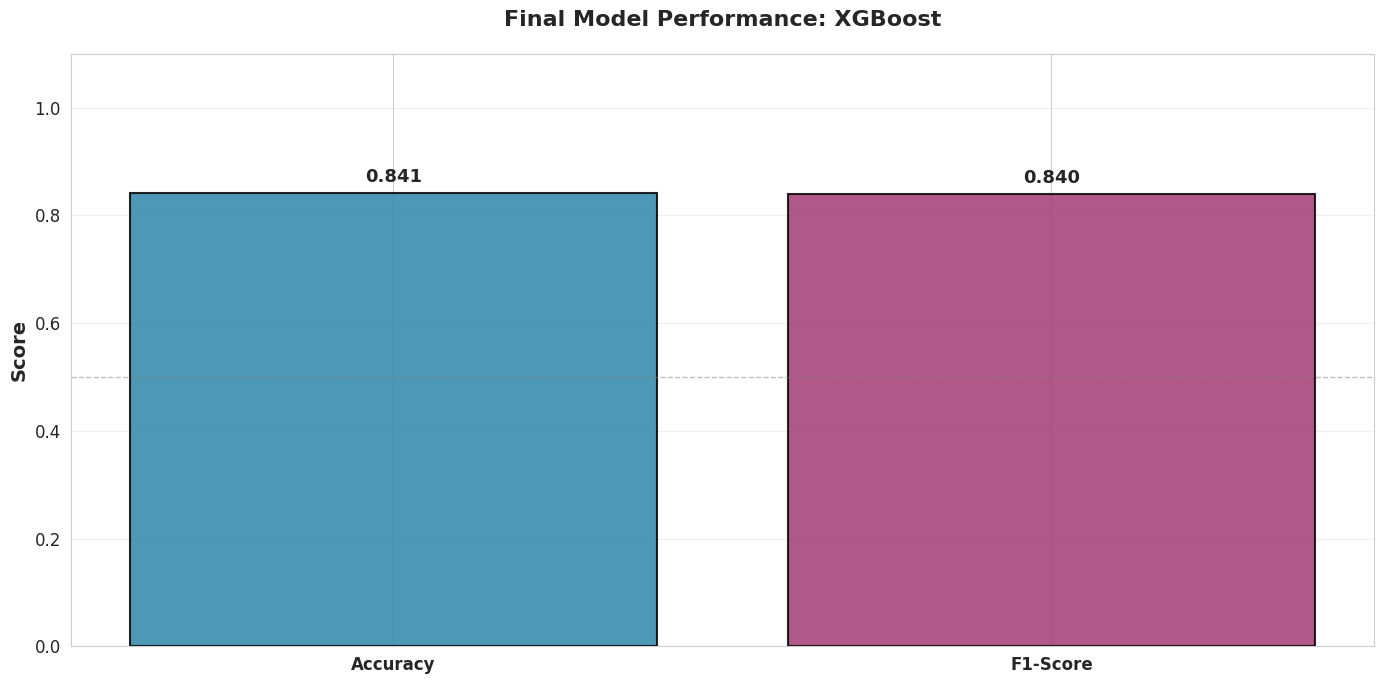


[Plot 2] Model Comparison


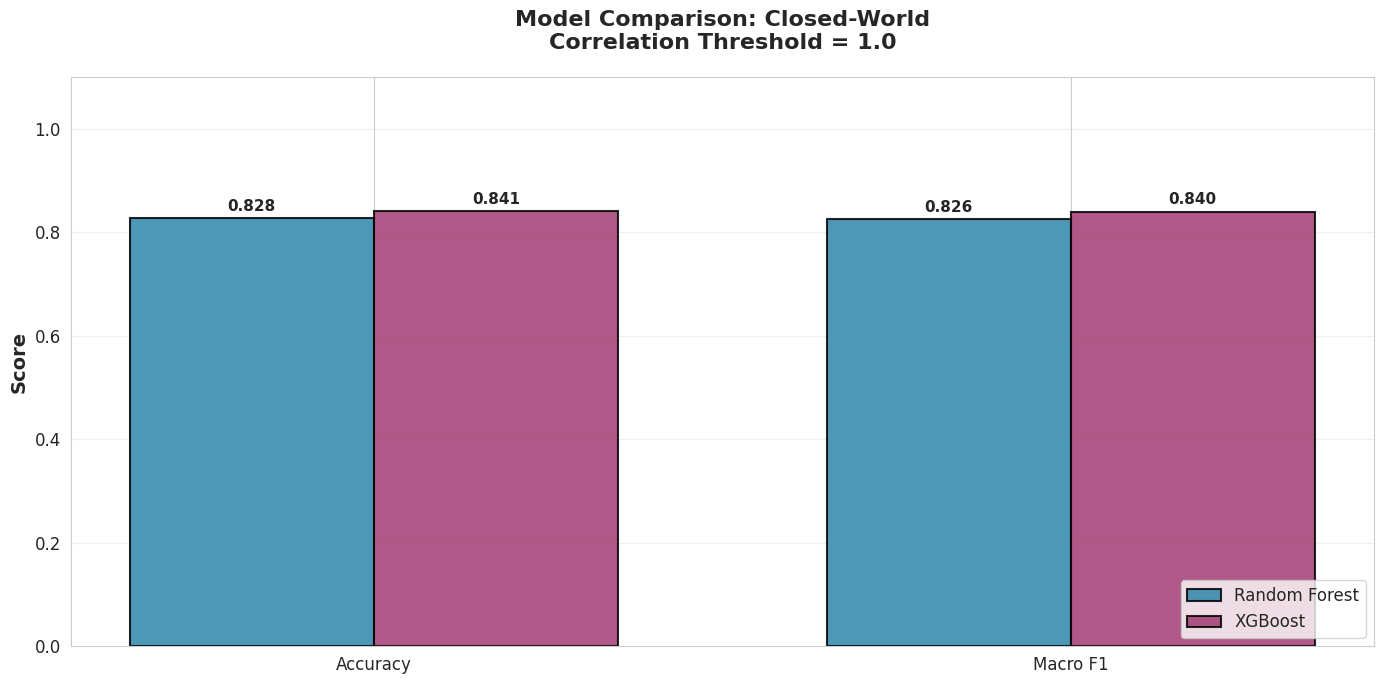


[Plot 3] Confusion Matrix


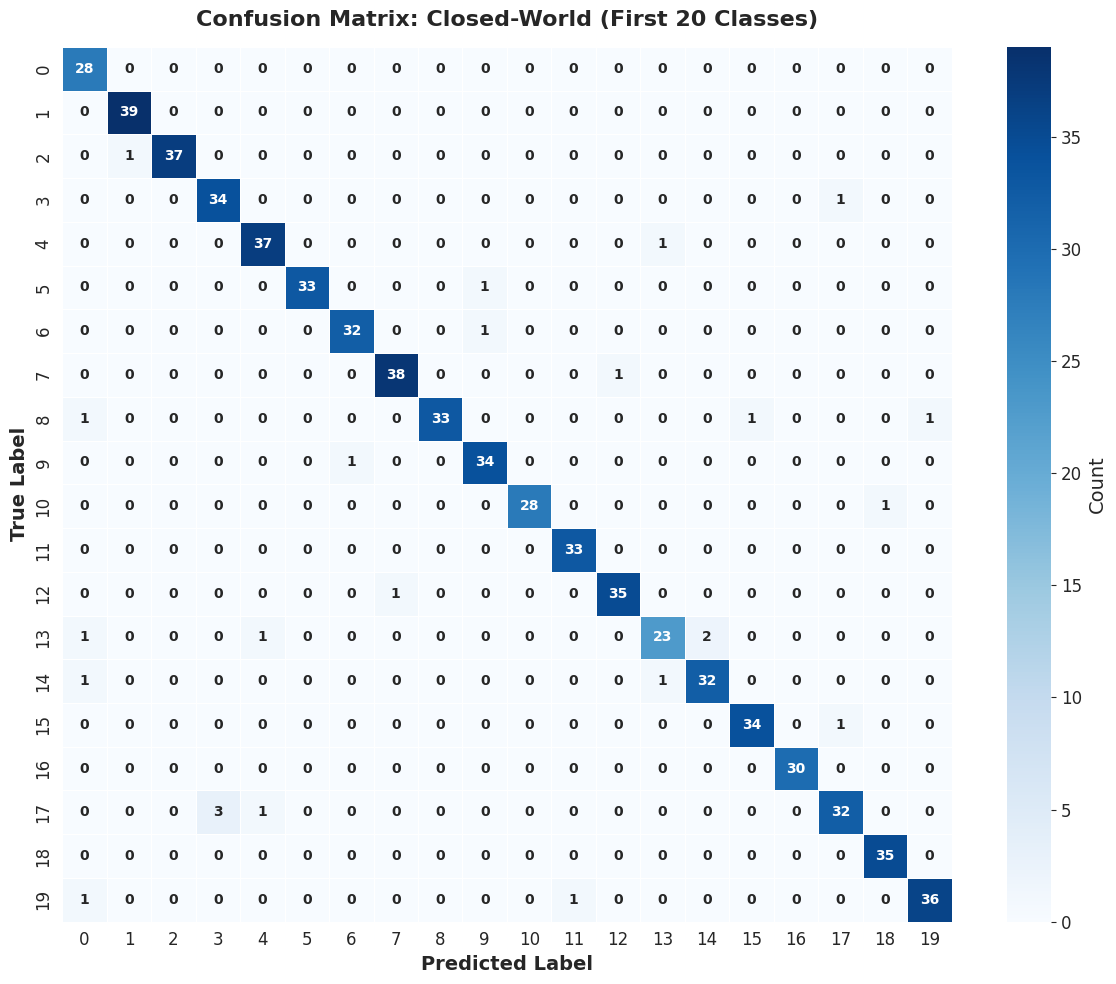


[Plot 4] Feature Importance


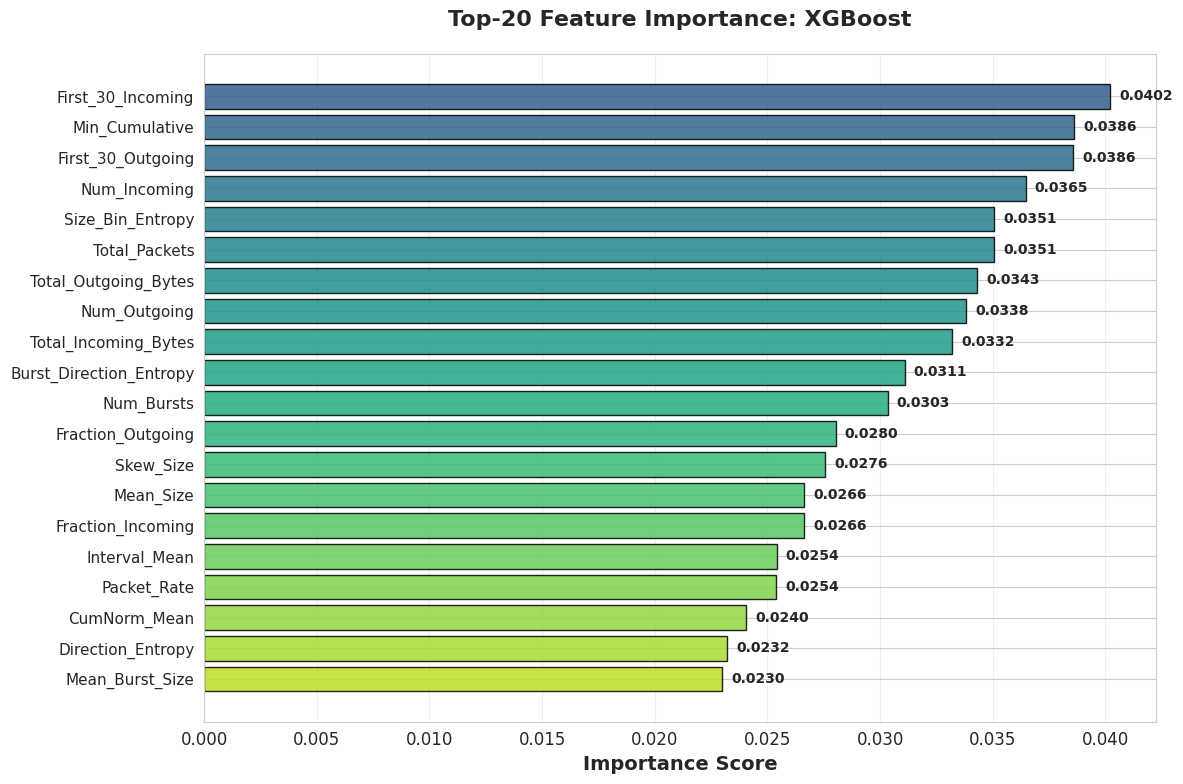


  FEATURE CATEGORY ANALYSIS
  • Timing Features:        8.2% (e.g., IAT, Duration, Rate)
  • Burst Features:        17.5% (e.g., Burst Length/Size)
  • Volume Features:       64.1% (e.g., Packet Count, Bytes)
  • Positional Features:    0.0% (e.g., First/Last 30)
  • Statistical Features:  10.2% (e.g., Mean, Std, Max)

   KEY INSIGHT: Volume features dominate (64.1%)
     → Volume-based patterns are most discriminative for this task


[Plot 5] SOTA Comparison


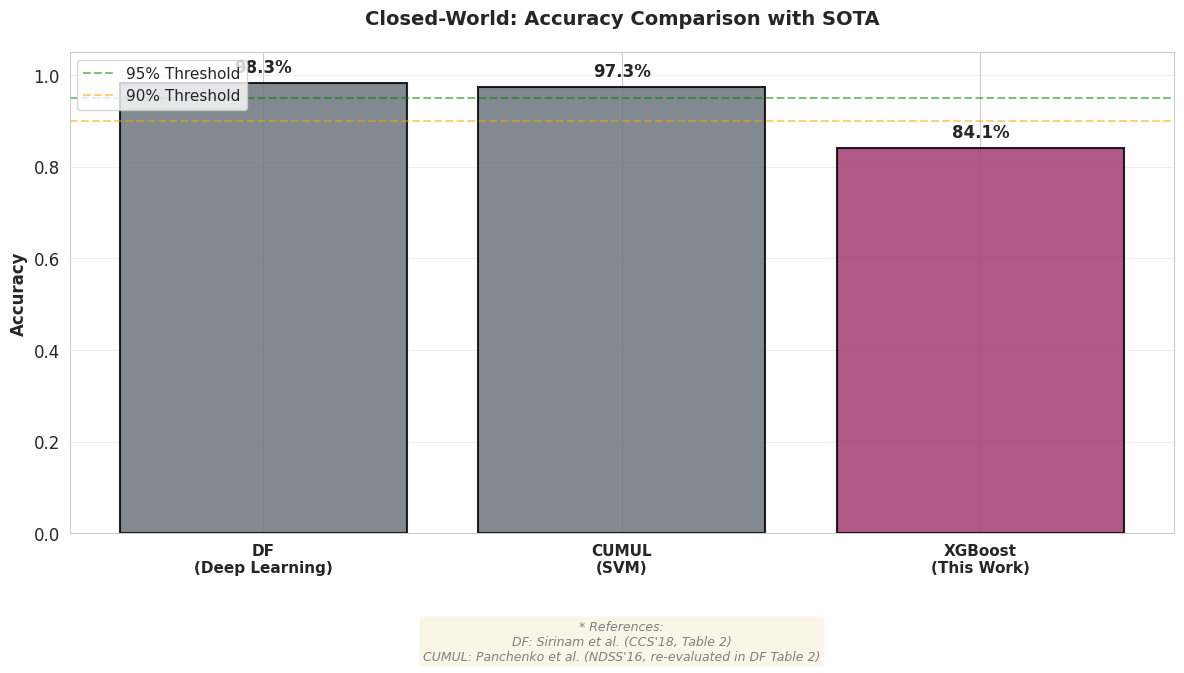

In [ ]:
setup_visualization_style()

if SCENARIO == 'closed':
    print("\n" + "="*80)
    print(" CLOSED-WORLD VISUALIZATION")
    print("="*80)

    # 1. Performance Metrics
    print("\n[Plot 1] Performance Metrics Bar Chart")
    metrics = {
        'Accuracy': FINAL_MODEL_INFO['accuracy'],
        'F1-Score': FINAL_MODEL_INFO['f1_score']
    }
    plot_performance_metrics_bar(metrics, f"Final Model Performance: {FINAL_MODEL_INFO['model']}", 'closed')

    # 2. Model Comparison
    print("\n[Plot 2] Model Comparison")
    plot_model_comparison(df_closed, FINAL_MODEL_INFO['corr_threshold'], 'Closed-World')

    # 3. Confusion Matrix
    print("\n[Plot 3] Confusion Matrix")
    plot_confusion_matrix_unified(y_test_viz, y_pred_viz, scenario='closed', max_classes=20)

    # 4. Feature Importance
    print("\n[Plot 4] Feature Importance")
    plot_feature_importance(
        final_clf, feature_names_viz,
        f"Top-20 Feature Importance: {FINAL_MODEL_INFO['model']}",
        top_n=20
    )

    # 5. SOTA Comparison
    print("\n[Plot 5] SOTA Comparison")
    plot_sota_comparison('closed', FINAL_MODEL_INFO['accuracy'], FINAL_MODEL_INFO['model'])


elif SCENARIO == 'open_binary':
    print("\n" + "="*80)
    print(" OPEN-WORLD BINARY VISUALIZATION")
    print("="*80)

    # 1. Binary Detection Metrics
    print("\n[Plot 1] Binary Detection Metrics")
    metrics = {
        'TPR (Recall)': FINAL_MODEL_INFO['tpr'],
        'FPR': FINAL_MODEL_INFO['fpr'],
        'TNR (Specificity)': 1 - FINAL_MODEL_INFO['fpr'],
        'Precision': FINAL_MODEL_INFO['precision'],
        'ROC-AUC': FINAL_MODEL_INFO['roc_auc']
    }
    plot_performance_metrics_bar(metrics, f"Binary Classification: {FINAL_MODEL_INFO['model']}", 'open_binary')

    # 2. Model Comparison
    print("\n[Plot 2] Model Comparison Chart")
    plot_model_comparison(
        df_binary,
        FINAL_MODEL_INFO['corr_threshold'],
        'Open-World Binary'
    )

    # 3. Confusion Matrix
    print("\n[Plot 3] Confusion Matrix")
    plot_confusion_matrix_unified(y_test_viz, y_pred_viz, scenario='open_binary', unmon_label=unmon_label)

    # 4. ROC & PR Curves
    print("\n[Plot 4] ROC & Precision-Recall Curves")
    plot_roc_pr_curves(y_test_viz, y_scores_viz, unmon_label, FINAL_MODEL_INFO['model'], scenario='open_binary')

    # 5. Feature Importance
    print("\n[Plot 5] Feature Importance")
    plot_feature_importance(
        final_clf, feature_names_viz,
        f"Top-20 Feature Importance: {FINAL_MODEL_INFO['model']}",
        top_n=20
    )

    # 6. SOTA Comparison
    print("\n[Plot 6] SOTA Comparison")
    plot_sota_comparison('open_binary', FINAL_MODEL_INFO['tpr'], FINAL_MODEL_INFO['model'])


elif SCENARIO == 'open_multi':
    print("\n" + "="*80)
    print(" OPEN-WORLD MULTI-CLASS VISUALIZATION")
    print("="*80)

    # 1. Performance Metrics
    print("\n[Plot 1] Multi-Class Performance Metrics")
    metrics = {
        'TPR (Recall)': FINAL_MODEL_INFO['tpr'],
        'FPR': FINAL_MODEL_INFO['fpr'],
        'TNR (Specificity)': 1 - FINAL_MODEL_INFO['fpr'],
        'Precision': FINAL_MODEL_INFO['precision'],
        'ROC-AUC': FINAL_MODEL_INFO['roc_auc'],
        'Overall Acc': FINAL_MODEL_INFO['overall_acc'],
        'Monitored Acc': FINAL_MODEL_INFO['monitored_acc']
    }
    plot_performance_metrics_bar(metrics, f"Open-Multi Performance: {FINAL_MODEL_INFO['model']}", 'open_multi')

    # 2. Model Comparison (CRITICAL FIX: Threshold 필터링)
    print("\n[Plot 2] Model Comparison")
    df_open_filtered = df_open[df_open['Threshold_Percentile'] == FINAL_MODEL_INFO['threshold_percentile']]
    plot_model_comparison(
        df_open_filtered,
        FINAL_MODEL_INFO['corr_threshold'],
        'Open-World Multi-Class',
        metric_focus=['TPR', 'FPR', 'Precision', 'ROC_AUC', 'overall_acc', 'monitored_acc']
    )

    # 3. Confusion Matrix (Dual)
    print("\n[Plot 3] Confusion Matrix (Binary + Top Classes)")
    plot_confusion_matrix_unified(
        y_test_viz, y_pred_viz,
        scenario='open_multi',
        unmon_label=unmon_label,
        max_classes=10
    )

    # 4. ROC & PR Curves
    print("\n[Plot 4] ROC & Precision-Recall Curves")
    plot_roc_pr_curves(y_test_viz, y_scores_viz, unmon_label, FINAL_MODEL_INFO['model'], scenario='open_multi')

    # 5. Threshold Sensitivity
    print("\n[Plot 5] Threshold Sensitivity Analysis")
    plot_threshold_sensitivity(
        df_open,
        FINAL_MODEL_INFO['model'],
        FINAL_MODEL_INFO['corr_threshold'],
        FINAL_MODEL_INFO['threshold_percentile'],
        scenario='open_multi'
    )

    # 6. Feature Importance
    print("\n[Plot 6] Feature Importance")
    plot_feature_importance(
        final_clf, feature_names_viz,
        f"Top-20 Feature Importance: {FINAL_MODEL_INFO['model']}",
        top_n=20
    )

    # 7. SOTA Comparison
    print("\n[Plot 7] SOTA Comparison")
    plot_sota_comparison('open_multi', FINAL_MODEL_INFO['tpr'], FINAL_MODEL_INFO['model'])